# ランダムフォレスト（回帰木）を用いたデータ予測

# 自作回帰木
【参考】https://fisproject.jp/2016/07/regression-tree-in-python/

In [163]:
import numpy as np

class Node(object):
    def __init__(self, max_depth = 3):
        self.left = None
        self.right = None
        self.max_depth = max_depth
        self.depth = None
        self.nSample = None
        self.val = None # ノードのサンプルの平均値
        self.f_index = None
        self.thrs = None
    
    def make_child_node(self, depth, features, target):
        # Input:
        #  depth[1×1]  current depth
        #  features[nSample×nDim]  explanatory variable
        #  target[nSample×1]  objective variable
        
        self.depth = depth
        self.nSample = features.shape[0]
        nDim = features.shape[1]
        
        self.val = np.mean(target)
                                                                                                                                                            
        # サンプルが一つの場合終了
        if len(target) == 1:
            return
        
        # ノード内の値が単一の場合終了
        if all(target == target[0]):
            return
        
        # 全てのサンプルが同じ特徴量を持つ場合終了
        if (features == features[0]).all():
            return

        
        max_gain, self.thrs, self.f_index = self.search_split_point(features, target)

        if self.depth == self.max_depth:
            return
        
        left_idx = features[:, self.f_index] <= self.thrs
        right_idx = features[:, self.f_index] > self.thrs
    
        self.left = Node(self.max_depth)
        self.right = Node(self.max_depth)
        
        self.left.make_child_node(depth+1, features[left_idx], target[left_idx])
        self.right.make_child_node(depth+1, features[right_idx], target[right_idx])
        
    def search_split_point(self, features, target):
        best_thrs = None # 分割に最適なしきい値
        best_f = None    # 分割に最適な説明変数
        max_gain = 0     # gainの最大値
        
        # 特徴量の順番をランダムにする
        f_loop_order = np.random.permutation(features.shape[1]).tolist()
        for idx in f_loop_order:
            f_selected = features[:,idx]
            for thrs in f_selected:
                left_idx = features[:, idx] <= thrs
                right_idx = features[:, idx] > thrs
                gain = self.calc_gain(target, target[left_idx], target[right_idx])
                if max_gain < gain:
                    max_gain = gain
                    best_thrs = thrs
                    best_f = idx
        
        return max_gain, best_thrs, best_f
                
    # 分割条件：MSE
    def calc_criterion(self, target):
        
        node_mean = np.mean(target)
        I = np.square(target - node_mean).mean()
        
        return I
                
    def calc_gain(self, target_p, target_cl, target_cr):

        cri_p = self.calc_criterion(target_p)
        cri_cl = self.calc_criterion(target_cl)
        cri_cr = self.calc_criterion(target_cr)

        gain = cri_p - (float(len(target_cl))/len(target_p)) * cri_cl \
                - (float(len(target_cr))/len(target_p)) * cri_cr
        
        return gain
    
    def predict(self, sample):
        if self.f_index == None or self.depth == self.max_depth:
            return self.val
        else:
            if sample[self.f_index] <= self.thrs:
                return self.left.predict(sample)
            elif sample[self.f_index] > self.thrs:
                return self.right.predict(sample)
        
        

In [23]:
class RegressionTree(object):
    def __init__(self, max_depth=3):
        self.tree = None
        self.max_depth = max_depth
    
    def fit(self, features, target):
        self.tree = Node(self.max_depth)
        self.tree.make_child_node(depth=0, features=features, target=target)
    
    def predict(self, samples):
        pred = []
        for s in samples:
            pred.append(self.tree.predict(s))
            
        return np.array(pred, dtype='float')
            
    def score(self, sample, target):
        return np.mean((self.predict(sample) - target)**2)
        #return sum(self.predict(sample) - target) / float(len(target))
        

# 自作ランダムフォレスト
【参考】https://qiita.com/deaikei/items/52d84ccfedbfc3b222cb
- サンプルだけではなく，特徴量についてもランダムに選択（ブートストラップ法：m個のサンプルから重複を許してm個とる）
- 「分類ではpの平方根、回帰の場合は3分のpの説明変数を抜き出すのをランダムフォレストの提案者は推奨」らしい
- 剪定は行わない

**※説明変数選択を行うと精度が急激に悪化するため，説明変数選択なしをDefaultに（feature_selection=False)**　\
→説明変数が12個と少ないため？データを変えて検証する必要あり

In [214]:
from numpy.random import choice

class RandomForest(object):
    def __init__(self, nTree=10, max_depth=3, random_state=None, feature_selection=False):
        self.nTree = nTree
        self.forest = [None] * self.nTree
        self.max_depth = max_depth
        self.feature_index = [None] * self.nTree
        self.random_state = random_state
        self.feature_selection = feature_selection
    
    def fit(self, features, target):
        sample_ind, feature_ind = self.bootstrap_sample(features, target)
        for i, (iSample_ind, iFeature_ind) in enumerate(zip(sample_ind, feature_ind)):
            tree = RegressionTree(self.max_depth)
            tree.fit(features[np.ix_(iSample_ind, iFeature_ind)], target[iSample_ind])
            self.forest[i] = tree 
            self.feature_index[i] = iFeature_ind

    def bootstrap_sample(self, features, target):
        nFeatures = features.shape[1]
        nSample = int(len(target))
        
        if self.random_state:
            np.random.seed(self.random_state)
            
        # ブートストラップサンプル＋特徴量のサンプリング
        sample_ind = [choice(nSample, size=nSample) for _ in range(self.nTree)] # sample index
        if self.feature_selection:
            feature_ind = [choice(nFeatures, size=int(np.floor(nFeatures/3))) for _ in range(self.nTree)] # feature index
        else:
            feature_ind = [choice(nFeatures, size=int(nFeatures), replace=False) for _ in range(self.nTree)] # feature indexfeature_ind = [choice(nFeatures, size=int(np.floor(nFeatures/3))) for _ in range(self.nTree)] # feature index
        

        return list(sample_ind), list(feature_ind)
    
    def predict(self, samples):
        pred_all_tree = [forest.predict(samples[:,ind]) for forest, ind in zip(self.forest, self.feature_index)]
        return sum(pred_all_tree)/len(pred_all_tree)
    
    def score(self, sample, target):
        return np.mean((self.predict(sample) - target)**2)

# scikit-learnのライブラリを使用した場合と結果を比較

In [6]:
# ボストン住宅価格データセットの読み込み
from sklearn.datasets import load_boston
boston = load_boston()

In [215]:
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

## original model
clf_m = RandomForest(nTree=10,max_depth=3, random_state=123, feature_selection=False)
clf_m.fit(boston.data, boston.target)

## scikit-learn model
clf_s = RandomForestRegressor(n_estimators=10, criterion='mse', max_depth=3, random_state=123)
clf_s = clf_s.fit(boston.data, boston.target)

## predict
pred_score = clf_m.score(boston.data, boston.target)
predicted = clf_s.predict(boston.data)

## output
#print('=============== predicted ===============')
#print(predicted)
#print('============== correct_ans ==============')
#print(target)
#print('=============== id_rate =================')
print("original model's score")
print(pred_score)

print("scikit-learn model's score")
print(np.mean((predicted - boston.target)**2))

print("R2")
print(clf_s.score(boston.data, boston.target)) # 決定係数R2

/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/naoko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice.


original model's score
12.086789199573309
scikit-learn model's score
12.129497260649504
R2
0.8563188695494743


In [216]:
# 交差検証
from sklearn.model_selection import KFold

kfold = KFold(n_splits=5, shuffle=True, random_state=None)

score_m = []
score_s = []
for train_index, test_index in kfold.split(boston.data, boston.target):
    clf_m.fit(boston.data[train_index],boston.target[train_index])
    clf_s.fit(boston.data[train_index],boston.target[train_index])
    
    
    predicted = clf_s.predict(boston.data[test_index])
    
    score_m.append(clf_m.score(boston.data[test_index], boston.target[test_index]))
    score_s.append(np.mean((predicted - boston.target[test_index])**2))
       
print("original model's score")
#score_m
print(np.mean(score_m))
print("scikit-learn model's score")
print(np.mean(score_s))

/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/naoko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice.
/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/naoko/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: Mean of empty slice.
/home/naoko/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/hom

original model's score
16.34005799590926
scikit-learn model's score
16.63754596237203


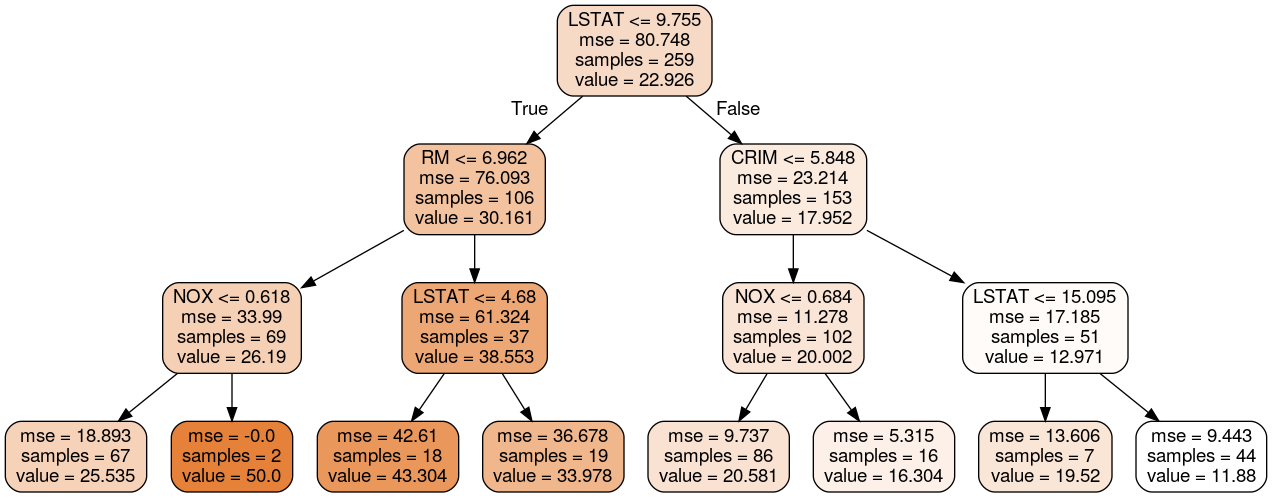

In [219]:
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

## visuzlization
dot_data = StringIO()

# 1つ目の決定木を可視化
dot_data = tree.export_graphviz(clf_s.estimators_[0], out_file = None, feature_names = boston.feature_names,
                            filled = True, rounded = True)


#tree.export_graphviz(clf, out_file=dot_data)
graph = pydotplus.graph_from_dot_data(dot_data)

graph.write_png("./result/graph_randomforest.png")

Image(graph.create_png())